# Imports

In [15]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
from collections import deque
import random
%matplotlib inline 

# Utils

In [4]:
class Deque():
    '''
    Deque with counter of elements
    '''
    def __init__(self, deq=[], maxlen=None):
        self.deque = deque(deq)
        self.l = max(maxlen, len(deq)) if maxlen else len(deq)
    def append(self, x):
        self.deque.append(x)
        self.l += 1
    def appendleft(self, x):
        self.deque.appendleft(x)
        self.l += 1
    def pop(self):
        x = self.deque.pop()
        self.l -= 1
        return x
    def popleft(self):
        x = self.deque.popleft()
        self.l -= 1
        return x

class Stack():
    '''
    Stack with counter of elements
    '''
    def __init__(self, iterable=[]):
        self.stack = list(iterable)
        self.l = len(iterable)
    def append(self, x):
        self.stack.append(x)
        self.l += 1
    def pop(self):
        x = self.stack.pop()
        self.l -= 1
        return x

def plot(G, pos=None, seed=20532, label_options=None):
    if pos == None:
        pos = nx.spring_layout(G, seed=seed)
    if label_options == None:
        label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
    if len(G) < 100:
        fs = 14
    else:
        fs = 10
    nx.draw(G, pos)
    nx.draw_networkx_labels(G, pos, font_size=fs, bbox=label_options)
    plt.show()


## Betweenness Centrality

In [13]:
'''
Betweenness centrality in unweighted graphs
Calculates approximate betweenness quickly when not k==None
calculates exact betweenness otherwise.
Algorithm Reference: https://kops.uni-konstanz.de/bitstream/handle/123456789/5739/algorithm.pdf
Algo divided into two parts: finding shortest paths and accumulate dependencies.
'''
def betweenness_centrality(G, k=None, seed=20532):
    '''
    Parameters: 
    G: nx.Graph
    k: The number of pivots, enables approximate version
    seed: seed for random state.

    Returns:
    betweenness: dict of node, betweenness_centrality pairs
    '''
    # G: networkx graph with nodes as integers
    betweenness = {x:0 for x in G.nodes}
    random.seed(seed)
    if k == None:
        nodes = G.nodes
    else:
        nodes = random.sample(list(G.nodes), k)
        
    for s in nodes:
        # initializations
        S = Stack()  # list as stack
        P = {}  # empty dict
        Q = Deque() # queue with right end as rear (insert) and left end as front (remove)
        sig = {x:0 for x in G.nodes}    # store to calculate ratio
        d = {x:-1 for x in G.nodes} # store shortest paths from s to all nodes
        
        # find shortest paths
        sig[s] = 1
        d[s] = 0
        Q.append(s)

        while Q.l > 0:
            v = Q.popleft()
            S.append(v)
            for w in G.neighbors(v):
                # w found for the first time?
                if d[w]<0:
                    Q.append(w)
                    d[w] = d[v] + 1
                # shortest path to w via v?
                if d[w] == d[v] + 1:
                    sig[w] += sig[v]
                    if w in P:
                        P[w].append(v)
                    else:
                        P[w] = [v]
        
        # accumulate dependencies
        dlta = {x:0 for x in G.nodes}
        # S returns vertices in order of non-increasing distance from s
        while S.l > 0:
            w = S.pop()
            if w in P: 
                for v in P[w]:
                    dlta[v] += (sig[v]/sig[w]) * (1 + dlta[w])
            if not w == s:
                betweenness[w] += dlta[w]
    
    # rescale output to range [0, 1]
    betweenness = _rescale(betweenness, len(G), k)

    return betweenness

'''
Reference: https://github.com/networkx/networkx/blob/e098dccd8be4e08497117fa39d66800907c2a932/networkx/algorithms/centrality/betweenness.py#L355
'''
def _rescale(betweenness, n, k):
    k = k
    if n < 2:
        scale = None  # no normalization
    else:
        scale = 1 / ((n - 1) * (n - 2)) 
    if scale is not None:
        if k is not None:
            scale = scale * n / k
        for v in betweenness:
            betweenness[v] *= scale
    return betweenness
       

## Closeness Centrality

In [36]:
'''
Closeness centrality in unweighted graphs
Formula Reference: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality
finding shortest paths similar to part one of betweenness. 
'''
def closeness_centrality(G, u=None):
    '''
    Parameters:
    G: nx.Graph
    u: single node. If a single node is passed, closeness centrality is found only for that node, 
    otherwise for all nodes

    Returns: float or dict of node wise closeness centrality depending upon the value of u. 
    '''
    if u == None:
        nodes = G.nodes
    else:
        nodes = [u]
    closeness = {x:0 for x in nodes}

    for s in nodes:
        # initializations
        Q = Deque() # queue with right end as rear (insert) and left end as front (remove)
        d = {x:-1 for x in G.nodes} # # store shortest paths from s to all nodes
        reachable = 0

        # finding shortest paths 
        d[s] = 0
        Q.append(s)
        while Q.l > 0:
            v = Q.popleft()
            reachable += 1
            for w in G.neighbors(v):
                # w found for the first time?
                if d[w]<0:
                    Q.append(w)
                    d[w] = d[v] + 1
        
        # Add up the shortest paths from s to all nodes
        sspsum = 0
        for v in G:
            sspsum += d[v]
        closeness[s] = (reachable - 1) / sspsum # closeness centrality = (#reachable nodes - 1) / sspsum
    if not u==None:
        return closeness[u]
    else:
        return closeness

## K-Core

In [ ]:
def k_core(G, k):
    '''
    Finds the subgraph containing all the k-cores of graph G.
    K-core explanation: https://www.geeksforgeeks.org/find-k-cores-graph/
    Parameters:
    G: nx.Graph
    k: number of cores
    Returns: nx.Graph (subgraph of G) having all k-cores

    Algorithm works in three steps:
    1. Remove all nodes with degree < k
    2. Recalculate degrees
    3. Repeat 1 and 2 till no more nodes are removed.

    '''
    flag = True
    count = 0
    while(flag):    # loop until any node is removed.
        count += 1
        flag = False
        deg_seq = list(G.degree())  
        for v, d in deg_seq:
            if d < k:
                G.remove_node(v)
                flag = True 
    return G

# Karate Club Network

============================== Node Count, Edge Count, Average Degree ==============================
Graph named "Zachary's Karate Club" with 34 nodes and 78 edges
Average Degree: 4.6


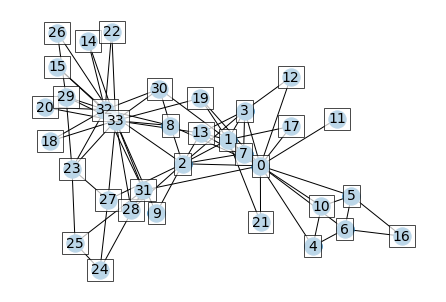

============================== Degree Distribution ==============================


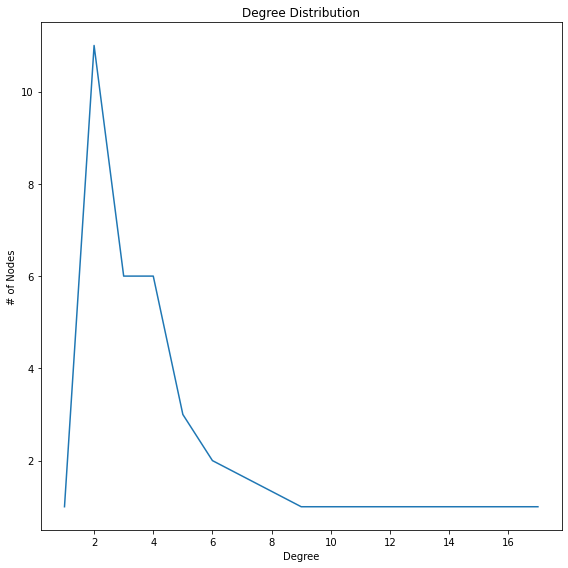

============================== Triangles ==============================
The number of triangles at nodes:
0 : 18
1 : 12
2 : 11
3 : 10
4 : 2
The total number of triangles in the graph is  45.0

============================== Diameter ==============================
The diameter of the graph is 5

============================== Connected Components ==============================
Component 1      Length : 34
Total connected components in the graph: 1
Size of largest connected component:  34

============================== Clustering Coefficient ==============================
The clustering coefficient of node:
0 : 0.15
1 : 0.33
2 : 0.24
3 : 0.67
4 : 0.67
The average clustering coefficient of the graph is 0.57



In [32]:
G = nx.karate_club_graph()
'''
Node count, Edge count, average degree
'''
print("="*30, "Node Count, Edge Count, Average Degree", "="*30)
print(nx.info(G)) 
print(f"Average Degree: {sum(dict(nx.degree(G)).values())/len(G.nodes):.2}")
'''
Plot graph
'''
seed = 20532
plot(G, seed=seed)
plt.show()
'''
Degree Distribution
'''
print("="*30, "Degree Distribution", "="*30)
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
ax = plt.subplot(111)
ax.plot(*np.unique(degree_sequence, return_counts=True))
ax.set_title("Degree Distribution")
ax.set_xlabel("Degree")
ax.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()
'''
Number of Triangles
'''
print("="*30, "Triangles", "="*30)
ntrid = nx.triangles(G)
print("The number of triangles at nodes:")
for i in range(5):
    print(i, ":", ntrid[i])
print("The total number of triangles in the graph is ", sum(ntrid.values())/3)
print()
'''
 Diameter
'''
print("="*30, "Diameter", "="*30)
d = nx.diameter(G)
print("The diameter of the graph is", d)
print()
'''
Connected Components
'''
print("="*30, "Connected Components", "="*30)
count = 0
comps = nx.connected_components(G)
largest_cc = 0
for comp in comps:
    count+=1
    print("Component", count, "     Length :", len(comp))
    if len(comp) > largest_cc:
        largest_cc = len(comp)
print("Total connected components in the graph:", count)
print("Size of largest connected component: ", largest_cc)
print()
'''
Clustering Coefficient
'''
print("="*30, "Clustering Coefficient", "="*30)
nclust = nx.clustering(G)
print("The clustering coefficient of node:")
for i in range(5):
    print(f"{i} : {nclust[i]:.2f}")
print(f"The average clustering coefficient of the graph is {sum(nclust.values())/len(G.nodes):.2f}")
print()


## Betweenness Example

In [33]:
'''
Betweenness Centrality
'''
print("="*30, "Betweenness Centrality", "="*30)
k = 6
betweenness = betweenness_centrality(G, k=k, seed=seed)
# Find betweenness of a given input set of nodes
nos = 10
input_set = sorted(random.sample(list(G.nodes), nos))
for v in input_set:
    print(f"{v} : {betweenness[v]:.4f}")
print()

print("="*30, "Verification through library function", "="*30)
betweenness = nx.betweenness_centrality(G, k, seed=seed)
for v in input_set:
    print(f"{v} : {betweenness[v]:.4f}")
print()


============================== Betweenness Centrality ==============================
2 : 0.14
4 : 0.00
5 : 0.01
11 : 0.00
13 : 0.03
15 : 0.00
16 : 0.00
24 : 0.00
25 : 0.01
31 : 0.08

============================== Verification through library function ==============================
2 : 0.14
4 : 0.00
5 : 0.01
11 : 0.00
13 : 0.03
15 : 0.00
16 : 0.00
24 : 0.00
25 : 0.01
31 : 0.08



In [ ]:
print("==================== Betweenness Centrality: Verification through library function ====================")
betweenness = nx.betweenness_centrality(G, k, seed=seed)
for v in input_set:
    print(v,":", betweenness[v])

==================== Betweenness Centrality: Verification through library function ====================
0 : 0.4825712481962482
2 : 0.1385193702902036
3 : 0.00789592352092352
4 : 0.0
5 : 0.01341540404040404
9 : 0.0007410413660413661
11 : 0.0
12 : 0.0
13 : 0.029173180214846883
15 : 0.0
16 : 0.0
17 : 0.0
18 : 0.0
20 : 0.0
24 : 0.002683080808080808
25 : 0.012550855780022447
26 : 0.0
30 : 0.012648809523809522
31 : 0.08150177368927368
32 : 0.1660443722943723


## Closeness Example

In [ ]:

'''
Calculates approximate closeness quickly when not k==None
calculates exact closeness otherwise.
'''
# Find closeness of a given input set of nodes
nos = 10
input_set = sorted(random.sample(list(G.nodes), nos))
print("="*30, "Closeness Centrality", "="*30)
for v in input_set:
    print(f"{v} : {closeness_centrality(G, v):.2f}")
print()

print("="*30, "Verification through library function", "="*30)
for v in input_set:
    print(f"{v} : {nx.closeness_centrality(G, v):.2f}")
print()


====================================== Closeness Centrality =================================
0 : 0.5689655172413793
1 : 0.4852941176470588
2 : 0.559322033898305
6 : 0.38372093023255816
8 : 0.515625
10 : 0.3793103448275862
12 : 0.3707865168539326
15 : 0.3707865168539326
16 : 0.28448275862068967
17 : 0.375
19 : 0.5
20 : 0.3707865168539326
22 : 0.3707865168539326
23 : 0.39285714285714285
24 : 0.375
25 : 0.375
28 : 0.4520547945205479
30 : 0.4583333333333333
31 : 0.5409836065573771
32 : 0.515625


In [ ]:
print("==================== Closeness Centrality: Verification through library function ====================")
for v in input_set:
    print(v,":", nx.closeness_centrality(G, v))

==================== Closeness Centrality: Verification through library function ====================
0 : 0.5689655172413793
1 : 0.4852941176470588
2 : 0.559322033898305
6 : 0.38372093023255816
8 : 0.515625
10 : 0.3793103448275862
12 : 0.3707865168539326
15 : 0.3707865168539326
16 : 0.28448275862068967
17 : 0.375
19 : 0.5
20 : 0.3707865168539326
22 : 0.3707865168539326
23 : 0.39285714285714285
24 : 0.375
25 : 0.375
28 : 0.4520547945205479
30 : 0.4583333333333333
31 : 0.5409836065573771
32 : 0.515625


## K-Core Example

==================================== K-Core for k=0 ======================================


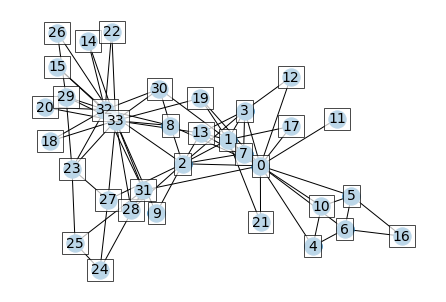

================= K-Core for k=0: Verification through library function ==================


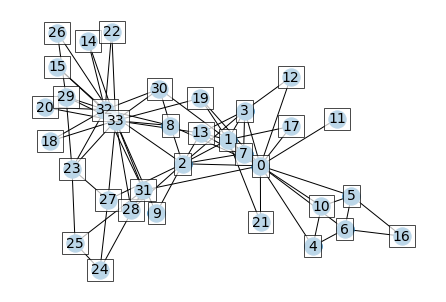

==================================== K-Core for k=1 ======================================


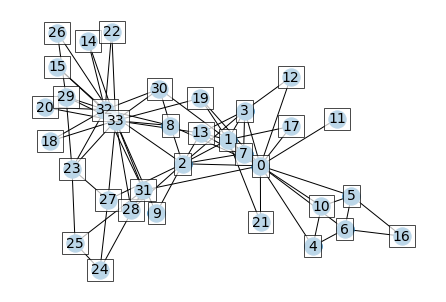

================= K-Core for k=1: Verification through library function ==================


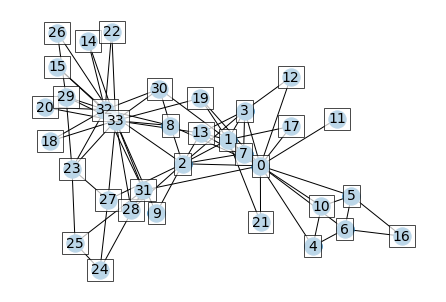

==================================== K-Core for k=2 ======================================


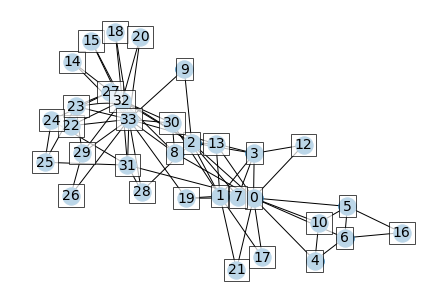

================= K-Core for k=2: Verification through library function ==================


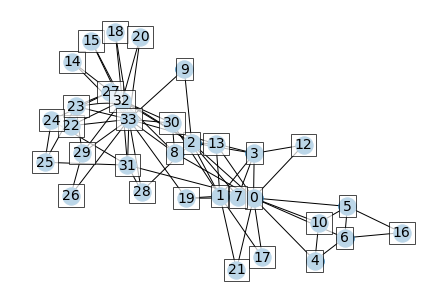

==================================== K-Core for k=3 ======================================


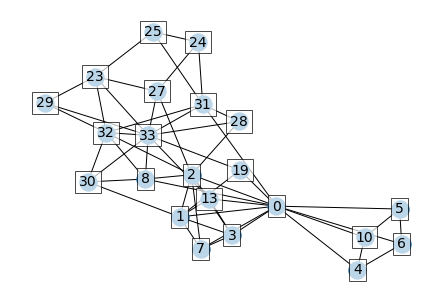

================= K-Core for k=3: Verification through library function ==================


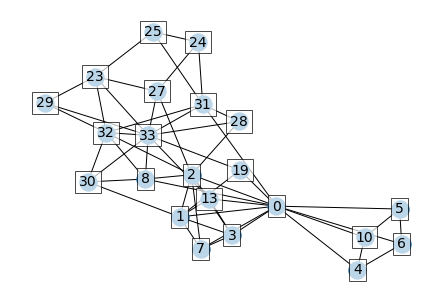

==================================== K-Core for k=4 ======================================


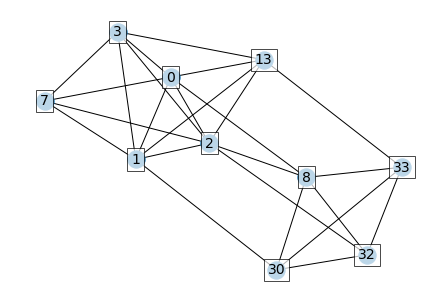

================= K-Core for k=4: Verification through library function ==================


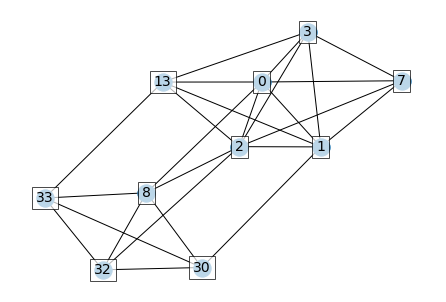

In [ ]:
# finding all k-cores for k in [1,4]
for k in range(1,5):
    print(f"="*30, f"K-Cores for k={k}", "="*30)
    plot(k_core(G.copy(), k), seed=seed)
    print(f"="*30, "Verification through library function", "="*30)
    sub = nx.k_core(G.copy(), k)
    plot(sub, seed=seed)

## Clique

In [ ]:
from networkx.algorithms.approximation import clique_removal

print("="*30, "Cliques", "="*30)
_, cliq_set = clique_removal(G) 
cliq_lens = map(len, cliq_set)
mx = mxval = 0
for val in cliq_lens:
    if mx < val:
        mx = val
        mxval += val

print("Max Clique size:", mx, "     Number:", mxval // mx)
print("Min Clique size:", mn, "      Number:", len(G.edges))    # Dyad is the min clique

Max Clique size: 5      Number: 1
Min Clique size: 2       Number: 78


# Ego Facebook

In [18]:
'''
Download and Extract Dataset
'''
!wget -q http://snap.stanford.edu/data/facebook_combined.txt.gz
!gzip -d /content/facebook_combined.txt.gz


============================== Node Count, Edge Count, Average Degree ==============================
Graph with 4039 nodes and 88234 edges
Average Degree: 43.69
============================== Degree Distribution ==============================


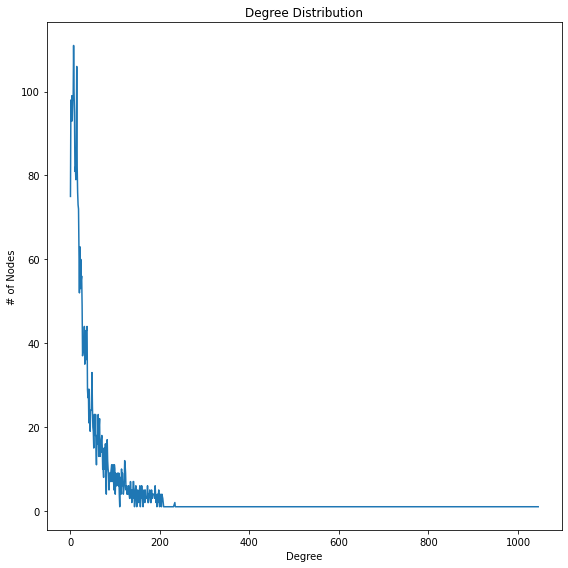

============================== Triangles ==============================
The number of triangles at nodes:
0 : 2519
1 : 57
2 : 40
3 : 86
4 : 39
The total number of triangles in the graph is  1612010.0

============================== Diameter ==============================
The diameter of the graph is 8

============================== Connected Components ==============================
Component 1      Length : 4039
Total connected components in the graph: 1
Size of largest connected component:  4039

============================== Clustering Coefficient ==============================
The clustering coefficient of node:
0 : 0.04
1 : 0.42
2 : 0.89
3 : 0.63
4 : 0.87
The average clustering coefficient of the graph is 0.61



In [35]:
G = nx.read_edgelist('facebook_combined.txt', create_using=nx.Graph(), nodetype=int)
'''
Node count, Edge count, average degree
'''
print("="*30, "Node Count, Edge Count, Average Degree", "="*30)
print(nx.info(G)) 
print(f"Average Degree: {sum(dict(nx.degree(G)).values())/len(G.nodes):.2f}")
'''
Plot graph
'''
seed = 20532
pos = nx.spring_layout(G, seed=seed)
nx.draw(G, pos, node_color="b", node_size=20, with_labels=False)
node_deg_list = G.degree()
largest_hub = sorted(node_deg_list, key=itemgetter(1))[-1][0]
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(G, pos, nodelist=[largest_hub], **options)
plt.show()
'''
Degree Distribution
'''
print("="*30, "Degree Distribution", "="*30)
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
ax = plt.subplot(111)
ax.plot(*np.unique(degree_sequence, return_counts=True))
ax.set_title("Degree Distribution")
ax.set_xlabel("Degree")
ax.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()
'''
Number of Triangles
'''
print("="*30, "Triangles", "="*30)
ntrid = nx.triangles(G)
print("The number of triangles at nodes:")
for i in range(5):
    print(i, ":", ntrid[i])
print("The total number of triangles in the graph is ", sum(ntrid.values())/3)
print()
'''
 Diameter
'''
print("="*30, "Diameter", "="*30)
d = nx.diameter(G)
print("The diameter of the graph is", d)
print()
'''
Connected Components
'''
print("="*30, "Connected Components", "="*30)
count = 0
comps = nx.connected_components(G)
largest_cc = 0
for comp in comps:
    count+=1
    print("Component", count, "     Length :", len(comp))
    if len(comp) > largest_cc:
        largest_cc = len(comp)
print("Total connected components in the graph:", count)
print("Size of largest connected component: ", largest_cc)
print()
'''
Clustering Coefficient
'''
print("="*30, "Clustering Coefficient", "="*30)
nclust = nx.clustering(G)
print("The clustering coefficient of node:")
for i in range(5):
    print(f"{i} : {nclust[i]:.2f}")
print(f"The average clustering coefficient of the graph is {sum(nclust.values())/len(G.nodes):.2f}")
print()


## Betweenness Example

In [34]:
'''
Calculates approximate betweenness quickly when not k==None
calculates exact betweenness otherwise.
'''
print("="*30, "Betweenness Centrality", "="*30)
k = 6
betweenness = betweenness_centrality(G, k=k, seed=seed)

# Find betweenness of a given input set of nodes
nos = 10
seed = random.randint(0, 100)
random.seed(seed)
input_set = sorted(random.sample(list(G.nodes), nos))
for v in input_set:
    print(f"{v} : {betweenness[v]:.4f}")

print("="*30, "Verification through library function", "="*30)
betweenness = nx.betweenness_centrality(G, k, seed=seed)
for v in input_set:
    print(f"{v} : {betweenness[v]:.4f}")

============================== Betweenness Centrality ==============================
2 : 0.1385
8 : 0.0607
12 : 0.0000
15 : 0.0000
18 : 0.0000
21 : 0.0000
28 : 0.0025
29 : 0.0030
30 : 0.0126
33 : 0.2266
============================== Verification through library function ==============================
2 : 0.1134
8 : 0.0634
12 : 0.0000
15 : 0.0000
18 : 0.0000
21 : 0.0000
28 : 0.0013
29 : 0.0000
30 : 0.0134
33 : 0.3471


## Closeness Example

In [37]:
'''
Calculates approximate closeness quickly when not k==None
calculates exact closeness otherwise.
'''
print("="*30, "Closeness Centrality", "="*30)
# Find closeness of a given input set of nodes
nos = 10
input_set = sorted(random.sample(list(G.nodes), nos))
for v in input_set:
    print(f"{v} : {closeness_centrality(G, v):.2f}")
print()

print("="*30, "Verification through library function", "="*30)
for v in input_set:
    print(f"{v} : {nx.closeness_centrality(G, v):.2f}")
print()

============================== Closeness Centrality ==============================
302 : 0.26
308 : 0.27
321 : 0.26
1343 : 0.32
1706 : 0.32
1772 : 0.32
2093 : 0.26
2531 : 0.26
3029 : 0.28
3169 : 0.28

============================== Verification through library function ==============================
302 : 0.26
308 : 0.27
321 : 0.26
1343 : 0.32
1706 : 0.32
1772 : 0.32
2093 : 0.26
2531 : 0.26
3029 : 0.28
3169 : 0.28



## K-Core Example

k = 19
==================================== K-Core ======================================


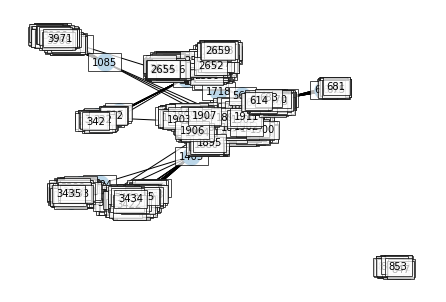

================= K-Core : Verification through library function ==================


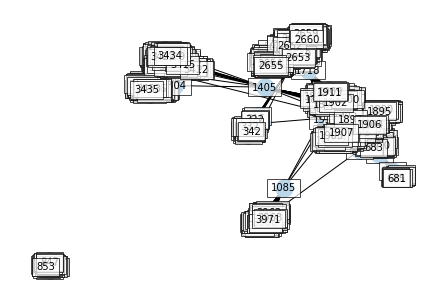

In [ ]:
k = random.randint(0, 20)   # select k from 0 to 20 randomly 
print("k =", k)
seed = random.randint(0, 20000)
print(f"="*30, f"K-Cores", "="*30)
# !takes some time
plot(k_core(G.copy(), k), seed=seed)
print("="*30, "Verification through library function", "="*30)
# !takes some time
sub = nx.k_core(G.copy(), k)
plot(sub, seed=seed)

## Cliques

In [ ]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(10000)
print(sys.getrecursionlimit())


3000
10000


In [ ]:
from networkx.algorithms.approximation import max_clique, clique_removal
print("="*30, "Cliques", "="*30)
_, cliq_set = clique_removal(G)    # !Either exhausts RAM or runs very long
cliq_lens = map(len, cliq_set)
mx = mxval = 0
for val in cliq_lens:
    if mx < val:
        mx = val
        mxval += val

print("Max Clique size:", mx, "     Number:", mxval // mx)
print("Min Clique size:", mn, "      Number:", len(G.edges))    # Dyad is the min clique